### Get length of video file

In [3]:
# Find the first JS log file in the directory and find out how long the video is. I assume that all log data in this entire directory has the same length of video.
import os
import re
SEC_IN_MIN = 60
seg_lens = ["5s", "10s", "20s"]
vid_length_pattern = re.compile("^LOG  [\d\.]+,([\d\.]+):.+$", re.M)

video_length_sec = None

for seg_len in seg_lens:
    dir_path = "./{seg_len}".format(seg_len = seg_len)
    
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        if not os.path.isdir(file_path): # Only looking to read directories (that are symlinks).
            continue
        jsLog_names = [filename for filename in os.listdir(file_path) if filename.startswith("Tester_") and filename.endswith(".log")]
        if len(jsLog_names) != 1:
            continue
        jsLog_name = jsLog_names[0]
        
        last_line = None
        with open(os.path.join(file_path, jsLog_name), "r") as jsLog:
            for line in jsLog:
                pass
            last_line = line
        
        match = vid_length_pattern.match(last_line)
        if not match:
            continue
        video_length_sec = match.group(1)
        break
        
    if video_length_sec is not None:
        break

video_length_sec = float(video_length_sec)
print("Video length (sec): {vidlen}".format(vidlen = video_length_sec))
video_length_min = video_length_sec / SEC_IN_MIN

Video length (sec): 634.566666


## Stalls

In [4]:
import os
import re

stall_start_pattern = re.compile("^STALL  started at ([\d\.]+) sec", re.M)
stall_end_pattern = re.compile("^STALL  ([\d]+) ms and stopped at [\d\.]+ sec", re.M)

def ComputeStallData(dir_path):
    jsLog_names = [filename for filename in os.listdir(dir_path) if filename.startswith("Tester_") and filename.endswith(".log")]
    if len(jsLog_names) != 1:
        return
    jsLog_name = jsLog_names[0]
    jsLog = open(os.path.join(dir_path, jsLog_name), "r")
    
    stall_starts = list()
    stall_lengths_ms = list()
    
    # Read through all the lines.
    while line := jsLog.readline():
        start_match = stall_start_pattern.match(line)
        if start_match:
            stall_start_sec = float(start_match.group(1))
            stall_starts.append(stall_start_sec)
        
        end_match = stall_end_pattern.match(line)
        if end_match:
            stall_len_ms = int(end_match.group(1))
            stall_lengths_ms.append(stall_len_ms)
    
    return stall_starts, stall_lengths_ms

In [30]:
import numpy as np
import os
import scipy.stats as st

seg_lens = ["5s", "10s", "20s"]
conf_interval = 0.95

avg_stall_cts = list()
avg_stall_cts_conf = list()
stdev_stall_cts = list()

avg_stall_lengths = list()
avg_stall_lengths_conf = list()
stdev_stall_lengths = list()

stall_start_times = list()

for seg_len in seg_lens:
    dir_path = "./{seg_len}".format(seg_len = seg_len)
    
    seglen_aggregate_stall_lengths = list()
    seglen_aggregate_stall_counts = list()
    seglen_aggregate_stall_starts = list()
    
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        if not os.path.isdir(file_path): # Only looking to read directories (that are symlinks).
            continue
        cur_stall_starts_sec, cur_stall_lengths_ms = ComputeStallData(file_path)
        seglen_aggregate_stall_lengths += cur_stall_lengths_ms
        seglen_aggregate_stall_counts.append(len(cur_stall_lengths_ms))
        seglen_aggregate_stall_starts.append(cur_stall_starts_sec)

    if len(seglen_aggregate_stall_lengths) == 0:
        seglen_aggregate_stall_lengths.append(0)
    if len(seglen_aggregate_stall_counts) == 0:
        seglen_aggregate_stall_counts.append(0)
    
    avg_cts = np.mean(seglen_aggregate_stall_counts)
    avg_stall_cts.append(avg_cts)
    # For some reason, when computing confidence intervals on a list of zeros, it just returns [nan, nan], which seems wrong to me. Manually returning [0, 0].
    if all([ct == 0 for ct in seglen_aggregate_stall_counts]):
        avg_stall_cts_conf.append([0, 0])
    else:
        avg_stall_cts_conf.append(st.norm.interval(alpha = conf_interval, loc = avg_cts, scale = st.sem(seglen_aggregate_stall_counts)))
    stdev_stall_cts.append(np.std(seglen_aggregate_stall_counts))
    
    avg_lengths = np.mean(seglen_aggregate_stall_lengths)
    avg_stall_lengths.append(avg_lengths)
    # For some reason, when computing confidence intervals on a list of zeros, it just returns [nan, nan], which seems wrong to me. Manually returning [0, 0].
    if all([ct == 0 for ct in seglen_aggregate_stall_lengths]):
        avg_stall_lengths_conf.append([0, 0])
    else:
        avg_stall_lengths_conf.append(st.norm.interval(alpha = conf_interval, loc = avg_lengths, scale = st.sem(seglen_aggregate_stall_lengths)))
    stdev_stall_lengths.append(np.std(seglen_aggregate_stall_lengths))
    
    stall_start_times.append(seglen_aggregate_stall_starts)

### Stall lengths

In [31]:
avg_stall_lengths

[4006.925925925926, 0.0, 0.0]

In [32]:
avg_stall_lengths_conf

[(3460.3095480952616, 4553.542303756591), [0, 0], [0, 0]]

In [33]:
stdev_stall_lengths

[3228.3970971265685, 0.0, 0.0]

### Stall counts

In [34]:
avg_stall_cts

[45.0, 0.0, 0.0]

In [35]:
avg_stall_cts_conf

[(36.84001922640961, 53.15998077359039), [0, 0], [0, 0]]

In [36]:
stdev_stall_cts

[5.887840577551898, 0.0, 0.0]

In [37]:
import numpy as np
stalls_permin = np.divide(avg_stall_cts, video_length_min)
print("Average stalls per minute of video (5s, 10s, 20s): {stallavg}".format(stallavg = stalls_permin))

Average stalls per minute of video (5s, 10s, 20s): [4.2548721 0.        0.       ]


### Stall totals

In [38]:
import numpy as np
stall_totals = np.multiply(avg_stall_cts, avg_stall_lengths)
print("Stall totals (# of stalls * length of stalls) (sec):\n{vols}".format(vols = stall_totals / 1000))

Stall totals (# of stalls * length of stalls) (sec):
[180.31166667   0.           0.        ]


In [39]:
import numpy as np
stall_totals_permin = np.divide(stall_totals, video_length_min)
print("Average stall totals per minute of video (seconds of stall / minute of video):\n{avgvol}".format(avgvol = stall_totals_permin / 1000))

Average stall totals per minute of video (seconds of stall / minute of video):
[17.04895731  0.          0.        ]


## Quality Changes

In [40]:
log_res_pattern = re.compile("^LOG  [^,]+,[^,]+,([\dx]+).+$")
qual_change_pattern = re.compile("^QUAL  at [\d\.]+ to ([\dx]+)$")

def ComputeQualChangeData(dir_path):
    jsLog_names = [filename for filename in os.listdir(dir_path) if filename.startswith("Tester_") and filename.endswith(".log")]
    if len(jsLog_names) != 1:
        return
    jsLog_name = jsLog_names[0]
    jsLog = open(os.path.join(dir_path, jsLog_name), "r")
    
    startRes = None
    resAmnts = dict()
    
    # Read through all the lines.
    while line := jsLog.readline():
        log_res_match = log_res_pattern.match(line)
        if log_res_match and startRes == None:
            # This is the first LOG line. Let's get the quality level in case it never changes so there are no QUAL entries.
            startRes = log_res_match.group(1)
            resAmnts[startRes] = resAmnts.get(startRes, 0) + 1
        
        match = qual_change_pattern.match(line)
        if match:
            resolution = match.group(1)
            resAmnts[resolution] = resAmnts.get(resolution, 0) + 1 # Increase number of occurrences of this resolution by 1.
    
    return resAmnts

In [41]:
seg_lens = ["5s", "10s", "20s"]
avg_qual_changes = list()
stdev_qual_changes = list()
for seg_len in seg_lens:
    #print("Segment length: " + seg_len)
    dir_path = "./{seg_len}".format(seg_len = seg_len)
    
    #run_ct = 0
    cur_qual_changes = list()
    #sum_qual_changes = 0
    
    for file_name in os.listdir(dir_path):
    #for run_idx in range(0, 3): # Index from [0..2].
        file_path = os.path.join(dir_path, file_name)
        if not os.path.isdir(file_path): # Only looking to read directories (that are symlinks).
            continue
        resAmnts = ComputeQualChangeData(file_path)
        
        #print(resAmnts)
        #run_ct += 1
        # Subtract one because the video always starts at a certain quality, that's not a quality change.
        qual_changes = sum(resAmnts.values()) - 1
        cur_qual_changes.append(qual_changes)
        #sum_qual_changes += qual_changes
        #seg_stall_ct_sum += stall_ct
        #seg_stall_len_sum += avg_stall_len_ms
        #print("Stall count: " + str(stall_ct))
        #print("Average stall length (ms): " + str(avg_stall_len_ms))
    
    avg_qual_changes.append(np.mean(cur_qual_changes))
    stdev_qual_changes.append(np.std(cur_qual_changes))
    #avg_qual_changes.append(sum_qual_changes / run_ct)
    #avg_stall_cts.append(seg_stall_ct_sum / run_ct)
    #avg_stall_lengths.append(seg_stall_len_sum / run_ct)

In [42]:
avg_qual_changes

[62.666666666666664, 0.0, 0.0]

In [43]:
stdev_qual_changes

[3.299831645537222, 0.0, 0.0]

## Quality Data

In [54]:
reso_to_bitrate_kbps = {
    "480x270": 2000,
    "640x360": 3000,
    "960x540": 5000,
    "1280x720": 10000,
    "1920x1080": 17200,
    "3840x2160": 40000,
}

In [44]:
log_res_pattern = re.compile("^LOG  [^,]+,[^,]+,([\dx]+).+$")

def ComputeQualData(dir_path):
    jsLog_names = [filename for filename in os.listdir(dir_path) if filename.startswith("Tester_") and filename.endswith(".log")]
    #print(jsLog_names)
    if len(jsLog_names) != 1:
        return
    jsLog_name = jsLog_names[0]
    jsLog = open(os.path.join(dir_path, jsLog_name), "r")
    
    resAmnts = dict()
    resOccurrences = list()
    
    # Read through all the lines.
    while line := jsLog.readline():
        log_res_match = log_res_pattern.match(line)
        if not log_res_match:
            continue

        startRes = log_res_match.group(1)
        #print(startRes)
        resAmnts[startRes] = resAmnts.get(startRes, 0) + 1
        resOccurrences.append(startRes)
        
    return resOccurrences

In [45]:
seg_lens = ["5s", "10s", "20s"]
avg_stall_cts = list()
avg_stall_lengths = list()
resOccurrences = list()
for seg_len in seg_lens:
    print("Segment length: " + seg_len)
    dir_path = "./{seg_len}".format(seg_len = seg_len)
    
    run_ct = 0
    seg_stall_ct_sum = 0
    seg_stall_len_sum = 0
    resQtys = list()
    
    for file_name in os.listdir(dir_path):
    #for run_idx in range(0, 3): # Index from [0..2].
        file_path = os.path.join(dir_path, file_name)
        if not os.path.isdir(file_path): # Only looking to read directories (that are symlinks).
            continue
        #resAmnts = ComputeQualData(file_path)
        resQtys += ComputeQualData(file_path)
        #print(resAmnts)
        #run_ct += 1
        #seg_stall_ct_sum += stall_ct
        #seg_stall_len_sum += avg_stall_len_ms
        #print("Stall count: " + str(stall_ct))
        #print("Average stall length (ms): " + str(avg_stall_len_ms))
    
    resOccurrences.append(resQtys)
    #avg_stall_cts.append(seg_stall_ct_sum / run_ct)
    #avg_stall_lengths.append(seg_stall_len_sum / run_ct)

Segment length: 5s
Segment length: 10s
Segment length: 20s


In [46]:
len(resOccurrences[2])

3876

In [47]:
from collections import Counter
import pandas as pd
resAmnts = list()
#resAmnts = pd.DataFrame()
for i in range(0, len(resOccurrences)):
    occDict = dict(Counter(resOccurrences[i]))
    occurrenceFrame = pd.DataFrame()
    occurrenceFrame["Resolution"] = occDict.keys()
    occurrenceFrame["Occurrences"] = occDict.values()
    totalOccurrences = occurrenceFrame["Occurrences"].sum()
    occurrenceFrame["Proportion"] = occurrenceFrame["Occurrences"] / totalOccurrences
    resAmnts.append(occurrenceFrame)

In [48]:
resAmnts[0]

,Resolution,Occurrences,Proportion
0,480x270,2525,0.548317
1,640x360,312,0.067752
2,960x540,518,0.112486
3,1280x720,404,0.087731
4,1920x1080,637,0.138328
5,3840x2160,209,0.045385


In [49]:
resAmnts[0].loc[resAmnts[0]["Occurrences"].idxmax()]
#resAmnts[0].loc[Occurrences == resAmnts[0]["Occurrences"]

Resolution      480x270
Occurrences        2525
Proportion     0.548317
Name: 0, dtype: object

In [30]:
resAmnts[1]

,Resolution,Occurrences,Proportion
0,480x270,3872,1.0


In [31]:
resAmnts[2]

,Resolution,Occurrences,Proportion
0,480x270,3876,1.0


In [67]:
resOccurrencesSorted = [sorted([reso_to_bitrate_kbps[res] for res in runData]) for runData in resOccurrences]

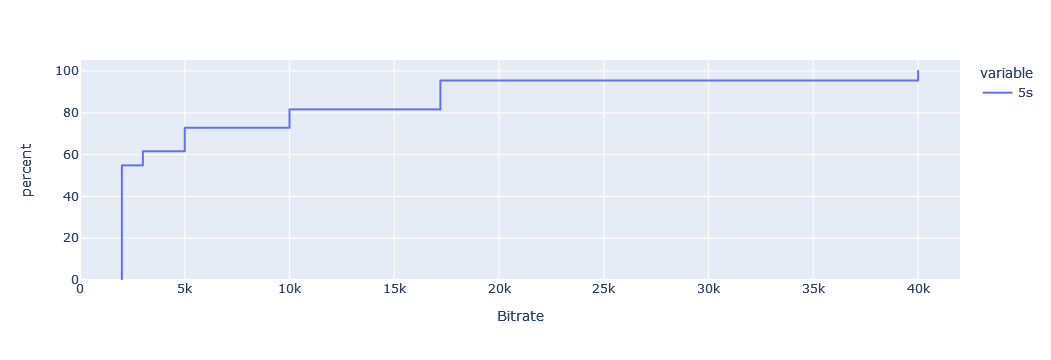

In [93]:
import plotly.express as px
import pandas as pd

resOccurrencesSortedDf = pd.DataFrame()
for idx, seglen in enumerate(seg_lens):
    #resOccurrencesSortedDf[seglen] = resOccurrencesSorted[idx]
    resOccurrencesSortedDf = pd.concat([resOccurrencesSortedDf, pd.DataFrame(resOccurrencesSorted[idx])], axis = 1)
resOccurrencesSortedDf.columns = seg_lens
#fig = px.ecdf(resOccurrencesSorted[0], ecdfnorm = "percent")
fig = px.ecdf(resOccurrencesSortedDf.loc[:, "5s"], ecdfnorm = "percent")
#fig.data
#fig.data[0].line.color = "red"
#fig.data[1].line.color = "green"
#fig.data[2].line.color = "blue"
#fig.update_xaxes(categoryorder = "array", categoryarray = ["480x270", "640x360", "960x540", "1280x720", "1920x1080", "3840x2160"])
fig.update_xaxes(title = "Bitrate", range = [0, 42000])
fig.show()

In [94]:
resOccurrencesSortedDf

,5s,10s,20s
0,2000,2000.0,2000.0
1,2000,2000.0,2000.0
2,2000,2000.0,2000.0
3,2000,2000.0,2000.0
4,2000,2000.0,2000.0
...,...,...,...
4600,40000,NaN,NaN
4601,40000,NaN,NaN
4602,40000,NaN,NaN
4603,40000,NaN,NaN


In [100]:
import plotly.graph_objects as plgo
import plotly.express as px

#fig = px.ecdf(resOccurrencesSortedDf, x = seg_lens, ecdfnorm = "percent")
#fig.update_xaxes(range = [0, 42000])
combinedFig = plgo.Figure()
seg_len_traces = []
for idx, seg_len in enumerate(seg_lens):
    seg_len_trace = px.ecdf(resOccurrencesSortedDf.iloc[:, idx], ecdfnorm = "percent")
    seg_len_traces += seg_len_trace
for seg_len_trace in seg_len_traces:
    combinedFig.add_trace(seg_len_trace)
combinedFig.update_xaxes(range = [0, 42000])
combinedFig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: ['data']

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

## RTT Time

In [4]:
import os
import csv
import numpy as np
import scipy.stats as st

conf_interval = 0.95

def calculate_rtt(folder_path):
    dir_path = folder_path
    #run_folders = ["Run0", "Run1", "Run2"]
    run_folders = [filename for filename in os.listdir(dir_path) if filename.startswith("Tester_") and filename.endswith(".log")]
    rtt_list = []

    for run_folder in run_folders:
        file_path = os.path.join(folder_path, run_folder, "UDPing_log.csv")
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader) # skip "Pinging..." row
            next(csv_reader) # skip "empty" row
            next(csv_reader) # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                rtt_list.append(float(row[2]))

    mean_rtt = np.mean(rtt_list)
    mean_rtt_conf = st.norm.interval(alpha = conf_interval, loc = mean_rtt, scale = st.sem(rtt_list))
    std_rtt = np.std(rtt_list)
    #avg_stall_cts_conf.append(st.norm.interval(alpha = conf_interval, loc = avg_cts, scale = st.sem(seglen_aggregate_stall_counts)))

    return (mean_rtt, mean_rtt_conf, std_rtt)

mean_rtt, mean_rtt_conf, std_rtt = calculate_rtt("./10s")
print("Mean RTT:", mean_rtt)
print("Mean RTT confidence interval:", mean_rtt_conf)
print("Standard deviation of RTT:", std_rtt)

Mean RTT: nan
Mean RTT confidence interval: (nan, nan)
Standard deviation of RTT: nan


C:\Users\TheQu\Anaconda3\envs\DS1010\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\TheQu\Anaconda3\envs\DS1010\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\TheQu\Anaconda3\envs\DS1010\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\TheQu\Anaconda3\envs\DS1010\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\TheQu\Anaconda3\envs\DS1010\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
import os
import csv
import numpy as np

def calculate_rtt(folder_path):
    folder_path = folder_path
    #run_folders = ["Run0", "Run1", "Run2"]
    run_folders = ["Results_2023-02-27T00_23_03.144711_glomma", "Results_2023-02-27T01_58_06.647754_glomma", "Results_2023-02-27T02_16_01.406052_glomma"]
    packet_loss_seqs=[]
    rtt_list = []
    receive_rates =[]
    prev_seq=-9999

    for run_folder in run_folders:
        file_path = os.path.join(folder_path, run_folder, "UDPing_log.csv")
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader) # skip "Pinging..." row
            next(csv_reader) # skip "empty" row
            next(csv_reader) # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                rtt = float(row[2])
                rtt_list.append(rtt)

                seq = int(row[3])
                if prev_seq != -9999 and seq != prev_seq + 1:
                    packet_loss_seqs.append(seq)
                prev_seq = seq


            send=int(csv_reader.__next__()[1])
            receive=int(csv_reader.__next__()[1])
            if receive == 0:
                receive_rates.append(0) # There are cases that all packets got lost.
            else:
                receive_rates.append(send/receive)

    mean_rtt = np.mean(rtt_list)
    std_rtt = np.std(rtt_list)
    mean_receive_rate=np.mean(receive_rates)
    std_receive_rate=np.std(receive_rates)

    return (mean_rtt, std_rtt,mean_receive_rate,std_receive_rate, packet_loss_seqs)

mean_rtt, std_rtt, mean_receive_rate, std_receive_rate, packet_loss_seqs= calculate_rtt("./5s")
print("Mean RTT:", mean_rtt)
print("Standard deviation of RTT:", std_rtt)
print("Mean Receive rate:", mean_receive_rate)
print("Standard deviation of Receive rate:", std_receive_rate)
print("Packet loss sequences:", packet_loss_seqs)

Mean RTT: 753.3373607540702
Standard deviation of RTT: 242.75784599438742
Mean Receive rate: 1.0031746452897699
Standard deviation of Receive rate: 0.00019219421857936768
Packet loss sequences: [19, 17, 20, 371, 1264, 1276, 1520, 1712, 2622, 2643, 2655, 0, 800, 810, 814, 826, 846, 1467, 1484, 2420, 2441, 0, 388, 414, 758, 813, 1941, 1955, 1969, 2321, 2332]


In [5]:
import os
import csv
import numpy as np

def calculate_rtt(folder_path):
    folder_path = folder_path
    #run_folders = ["Run0", "Run1", "Run2"]
    run_folders = ["Results_2023-02-27T00_23_03.144711_glomma", "Results_2023-02-27T01_58_06.647754_glomma", "Results_2023-02-27T02_16_01.406052_glomma"]
    all_packet_loss_seqs=[]
    rtt_list = []
    receive_rates =[]

    for run_folder in run_folders:
        prev_seq=-9999
        packet_loss_seqs=[]
        file_path = os.path.join(folder_path, run_folder, "UDPing_log.csv")
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader) # skip "Pinging..." row
            next(csv_reader) # skip "empty" row
            next(csv_reader) # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                rtt = float(row[2])
                rtt_list.append(rtt)

                seq = int(row[3])
                if prev_seq != -9999 and seq != prev_seq + 1:
                    packet_loss_seqs.append(seq)
                prev_seq = seq


            all_packet_loss_seqs.append(packet_loss_seqs)
            send=int(csv_reader.__next__()[1])
            receive=int(csv_reader.__next__()[1])
            if receive == 0:
                receive_rates.append(0) # There are cases that all packets got lost.
            else:
                receive_rates.append(send/receive)


    mean_rtt = np.mean(rtt_list)
    std_rtt = np.std(rtt_list)
    mean_receive_rate=np.mean(receive_rates)
    std_receive_rate=np.std(receive_rates)

    return (mean_rtt, std_rtt,mean_receive_rate,std_receive_rate, all_packet_loss_seqs)

mean_rtt, std_rtt, mean_receive_rate, std_receive_rate, packet_loss_seqs= calculate_rtt("./5s")
print("Mean RTT:", mean_rtt)
print("Standard deviation of RTT:", std_rtt)
print("Mean Receive rate:", mean_receive_rate)
print("Standard deviation of Receive rate:", std_receive_rate)
print("Packet loss sequences:", packet_loss_seqs)

Mean RTT: 753.3373607540702
Standard deviation of RTT: 242.75784599438742
Mean Receive rate: 1.0031746452897699
Standard deviation of Receive rate: 0.00019219421857936768
Packet loss sequences: [[19, 17, 20, 371, 1264, 1276, 1520, 1712, 2622, 2643, 2655], [800, 810, 814, 826, 846, 1467, 1484, 2420, 2441], [388, 414, 758, 813, 1941, 1955, 1969, 2321, 2332]]


In [7]:
import os
import csv
import numpy as np

def find_missing_and_out_of_order_values(data):
    missing_values = []
    out_of_order_values = []

    for i, value in enumerate(data):
        # Check if the current value is missing
        if i not in data:
            missing_values.append(i)

        # Check if the current value is out of order
        if i > 0 and value < data[i-1]:
            out_of_order_values.append(value)

    return missing_values, out_of_order_values

def calculate_rtt(folder_path):
    folder_path = folder_path
    #run_folders = ["Run0", "Run1", "Run2"]
    run_folders = ["Results_2023-02-27T00_23_03.144711_glomma", "Results_2023-02-27T01_58_06.647754_glomma", "Results_2023-02-27T02_16_01.406052_glomma"]
    all_packet_loss_seqs=[]
    all_missing_seqs=[]
    all_out_of_order_seqs=[]
    rtt_list = []
    receive_rates =[]

    for run_folder in run_folders:
        file_path = os.path.join(folder_path, run_folder, "UDPing_log.csv")
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader) # skip "Pinging..." row
            next(csv_reader) # skip "empty" row
            next(csv_reader) # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                rtt = float(row[2])
                rtt_list.append(rtt)

            send=int(csv_reader.__next__()[1])
            receive=int(csv_reader.__next__()[1])
            if receive == 0:
                receive_rates.append(0) # There are cases that all packets got lost.
            else:
                receive_rates.append(send/receive)

        #get the seq that is not one above the previous seq
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            prev_seq=-9999
            packet_loss_seqs=[]
            next(csv_reader)  # skip "Pinging..." row
            next(csv_reader)  # skip "empty" row
            next(csv_reader)  # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break

                seq = int(row[3])
                if prev_seq != -9999 and seq != prev_seq + 1:
                    packet_loss_seqs.append(seq)
                prev_seq = seq

            print(packet_loss_seqs)
            all_packet_loss_seqs.append(packet_loss_seqs)

        #Find missing and out of order values
        with open(file_path, "r") as csv_file:
            seq_column = []
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # skip "Pinging..." row
            next(csv_reader)  # skip "empty" row
            next(csv_reader)  # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                seq_column.append(int(row[3]))
            missing_values, out_of_order_values=find_missing_and_out_of_order_values(seq_column)
            all_missing_seqs.append(missing_values)
            all_out_of_order_seqs.append(out_of_order_values)

    mean_rtt = np.mean(rtt_list)
    std_rtt = np.std(rtt_list)
    mean_receive_rate=np.mean(receive_rates)
    std_receive_rate=np.std(receive_rates)

    return (mean_rtt, std_rtt,mean_receive_rate,std_receive_rate, all_packet_loss_seqs, all_missing_seqs, all_out_of_order_seqs)

mean_rtt, std_rtt, mean_receive_rate, std_receive_rate, packet_loss_seqs, missing_seqs, out_of_order_seqs= calculate_rtt(".\\5s")
print("Mean RTT:", mean_rtt)
print("Standard deviation of RTT:", std_rtt)
print("Mean Receive rate:", mean_receive_rate)
print("Standard deviation of Receive rate:", std_receive_rate)
print("Packet loss sequences:", packet_loss_seqs)
print("Missing sequences:",missing_seqs)
print("Out of order sequences:",out_of_order_seqs)

[19, 17, 20, 371, 1264, 1276, 1520, 1712, 2622, 2643, 2655]
[800, 810, 814, 826, 846, 1467, 1484, 2420, 2441]
[388, 414, 758, 813, 1941, 1955, 1969, 2321, 2332]
Mean RTT: 753.3373607540702
Standard deviation of RTT: 242.75784599438742
Mean Receive rate: 1.0031746452897699
Standard deviation of Receive rate: 0.00019219421857936768
Packet loss sequences: [[19, 17, 20, 371, 1264, 1276, 1520, 1712, 2622, 2643, 2655], [800, 810, 814, 826, 846, 1467, 1484, 2420, 2441], [388, 414, 758, 813, 1941, 1955, 1969, 2321, 2332]]
Missing sequences: [[370, 1263, 1275, 1519, 1711, 2620, 2621, 2642, 2654], [799, 809, 813, 825, 845, 1466, 1483, 2419, 2439, 2440], [387, 413, 757, 812, 1940, 1954, 1968, 2320, 2331]]
Out of order sequences: [[17], [], []]


In [5]:
import os
import csv
import numpy as np

def find_missing_and_out_of_order_values(data):
    missing_values = []
    out_of_order_values = []

    for i, value in enumerate(data):
        # Check if the current value is missing
        if i not in data:
            missing_values.append(i)

        # Check if the current value is out of order
        if i > 0 and value < data[i-1]:
            out_of_order_values.append(value)

    return missing_values, out_of_order_values

def calculate_rtt(folder_path):
    folder_path = folder_path
    #run_folders = ["Run0", "Run1", "Run2"]
    run_folders = ["Results_2023-02-27T00_23_03.144711_glomma", "Results_2023-02-27T01_58_06.647754_glomma", "Results_2023-02-27T02_16_01.406052_glomma"]
    all_packet_loss_seqs=[]
    all_missing_seqs=[]
    all_out_of_order_seqs=[]
    rtt_list = []
    receive_rates =[]

    for run_folder in run_folders:
        file_path = os.path.join(folder_path, run_folder, "UDPing_log.csv")
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader) # skip "Pinging..." row
            next(csv_reader) # skip "empty" row
            next(csv_reader) # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                rtt = float(row[2])
                rtt_list.append(rtt)

            send=int(csv_reader.__next__()[1])
            receive=int(csv_reader.__next__()[1])
            if receive == 0:
                receive_rates.append(0) # There are cases that all packets got lost.
            else:
                receive_rates.append(send/receive)

        #get the seq that is not one above the previous seq
        with open(file_path, "r") as csv_file:
            csv_reader = csv.reader(csv_file)
            prev_seq=-9999
            packet_loss_seqs=[]
            next(csv_reader)  # skip "Pinging..." row
            next(csv_reader)  # skip "empty" row
            next(csv_reader)  # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break

                seq = int(row[3])
                if prev_seq != -9999 and seq != prev_seq + 1:
                    packet_loss_seqs.append(seq)
                prev_seq = seq

            print(packet_loss_seqs)
            all_packet_loss_seqs.append(packet_loss_seqs)

        #Find missing and out of order values
        with open(file_path, "r") as csv_file:
            seq_column = []
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # skip "Pinging..." row
            next(csv_reader)  # skip "empty" row
            next(csv_reader)  # skip header row
            for row in csv_reader:
                if "Ping statistics" in row[0]:
                    break
                seq_column.append(int(row[3]))
            missing_values, out_of_order_values=find_missing_and_out_of_order_values(seq_column)
            all_missing_seqs.append(missing_values)
            all_out_of_order_seqs.append(out_of_order_values)

    mean_rtt = np.mean(rtt_list)
    std_rtt = np.std(rtt_list)
    mean_receive_rate=np.mean(receive_rates)
    std_receive_rate=np.std(receive_rates)

    return (mean_rtt, std_rtt,mean_receive_rate,std_receive_rate, all_packet_loss_seqs, all_missing_seqs, all_out_of_order_seqs)

mean_rtt, std_rtt, mean_receive_rate, std_receive_rate, packet_loss_seqs, missing_seqs, out_of_order_seqs= calculate_rtt(".\\5s")
print("Mean RTT:", mean_rtt)
print("Standard deviation of RTT:", std_rtt)
print("Mean Receive rate:", mean_receive_rate)
print("Standard deviation of Receive rate:", std_receive_rate)
print("Packet loss sequences:", packet_loss_seqs)
print("Missing sequences:",missing_seqs)
print("Out of order sequences:",out_of_order_seqs)

[19, 17, 20, 371, 1264, 1276, 1520, 1712, 2622, 2643, 2655]
[800, 810, 814, 826, 846, 1467, 1484, 2420, 2441]
[388, 414, 758, 813, 1941, 1955, 1969, 2321, 2332]
Mean RTT: 753.3373607540702
Standard deviation of RTT: 242.75784599438742
Mean Receive rate: 1.0031746452897699
Standard deviation of Receive rate: 0.00019219421857936768
Packet loss sequences: [[19, 17, 20, 371, 1264, 1276, 1520, 1712, 2622, 2643, 2655], [800, 810, 814, 826, 846, 1467, 1484, 2420, 2441], [388, 414, 758, 813, 1941, 1955, 1969, 2321, 2332]]
Missing sequences: [[370, 1263, 1275, 1519, 1711, 2620, 2621, 2642, 2654], [799, 809, 813, 825, 845, 1466, 1483, 2419, 2439, 2440], [387, 413, 757, 812, 1940, 1954, 1968, 2320, 2331]]
Out of order sequences: [[17], [], []]


## Time to Start Playing

In [35]:
import os
import re

log_video_time_pattern = re.compile("^LOG  ([\d\.]+),([\d\.]+):.+$")
#stall_pattern = re.compile("^STALL  ([\d]+) ms and stopped at [\d\.]+ sec", re.M)

def ComputeTimeToStart(dir_path):
    jsLog_names = [filename for filename in os.listdir(dir_path) if filename.startswith("Tester_") and filename.endswith(".log")]
    if len(jsLog_names) != 1:
        return
    jsLog_name = jsLog_names[0]
    jsLog = open(os.path.join(dir_path, jsLog_name), "r")
    
    # Read through all the lines.
    while line := jsLog.readline():
        match = log_video_time_pattern.match(line)
        if match:
            absolute_time = float(match.group(1))
            video_time = float(match.group(2))
            if video_time > 0:
                # We've found when the video started playing.
                return absolute_time
    
    return -1

In [36]:
import numpy as np
import scipy.stats as st

conf_interval = 0.95
seg_lens = ["5s", "10s", "20s"]

avg_start_times_sec = list()
avg_start_times_sec_conf = list()
stdev_start_times_sec = list()

for seg_len in seg_lens:
    dir_path = "./{seg_len}".format(seg_len = seg_len)
    
    start_times_sec = list()
    
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        if not os.path.isdir(file_path): # Only looking to read directories (that are symlinks).
            continue
        start_time_sec = ComputeTimeToStart(file_path)
        start_times_sec.append(start_time_sec)
    
    avg_start_time_sec = np.mean(start_times_sec)
    avg_start_times_sec.append(avg_start_time_sec)
    #avg_start_times_sec_conf.append(st.norm.interval(alpha = conf_interval, loc = avg_start_time_sec, scale = st.sem(start_times_sec)))
    avg_start_times_sec_conf.append(st.t.interval(alpha = conf_interval,
                                                  df = len(start_times_sec) - 1,
                                                  loc = avg_start_time_sec,
                                                  scale = st.sem(start_times_sec)))
    stdev_start_times_sec.append(np.std(start_times_sec))

In [37]:
avg_start_times_sec

[6.843666666666667, 11.073333333333336, 11.484333333333334]

In [38]:
avg_start_times_sec_conf

[(4.896476096359205, 8.790857236974128),
 (10.242388959287464, 11.904277707379208),
 (9.623035512293361, 13.345631154373306)]

In [39]:
stdev_start_times_sec

[0.6400105901901589, 0.27311820802640663, 0.6117790087568836]